## RNA decay fitting of models
Author: Robert Ietswaart, 20200813
License: BSD2.  
Load modules j3dl and activate virtual environment using j4RNAdecay on O2.
Python v3.7.4, pytorch v1.4 

For Erik's project: perform kin/kout fitting of TC conversion rates at early time point from later time points.

In [14]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
import seaborn as sns
from scipy.optimize import least_squares
from scipy.stats import beta
import new_total_ratio as ntr
import aic

In [96]:
#TL2: Calibration curves: 20200813
# path = os.path.join('/n','groups','churchman','ri23','RNAdecay')
# filename = 'Timelapse_CAL_MMinformed4_lenient.binomEstimated.tsv' #'Timelapse_CAL_MMinformed4_lenient.binomOverlapEstimated.tsv'

##TL3: 20201011: 50uM concentration experiment
path = os.path.join('/n','groups','churchman','mc348','TimelapseSeq','Hela_2020_09',
                    'GS_TL3_MMinformed4_lenient_modeAll')
filename = 'TL3_MMinformed4_lenient_modeAll.binomEstimated.tsv'
TC_all = pd.read_csv(os.path.join(path,filename), sep='\t')

#TL2 MT
# filename = 'Timelapse1_MTall_MMinformed4_lenient.binomEstimated.tsv' #'Timelapse1_MTall_MMinformed4_lenient.binomOverlapEstimated.tsv'
#TL3 MT
path = os.path.join('/n','groups','churchman','mc348','TimelapseSeq','Hela_2020_09',
                    'GS_TL3_MT_MMinformed4_lenient_modeAll')
filename = 'TL3_MT_MMinformed4_lenient_modeAll.binomEstimated.tsv'

TC_MT = pd.read_csv(os.path.join(path,filename), sep='\t') 

In [16]:
TC_all#.head()
# TC.columns

,Condition,conv_old,conv_new,p_new_lower,p_new,p_new_upper,Status
0,TL3_no4sU,0.001841,0.077487,0.003896,0.004051,0.004208,Too few
1,TL3_0m,0.001841,0.077487,0.003896,0.004051,0.004208,Too few
2,TL3_7m,0.001831,0.092128,0.005647,0.005818,0.005992,Too few
3,TL3_15m,0.001866,0.054846,0.007994,0.008177,0.008361,Too few
4,TL3_30m,0.001991,0.026067,0.050030,0.050574,0.051118,Ok
5,TL3_45m,0.001912,0.030324,0.090088,0.090652,0.091212,Ok
6,TL3_60m,0.001831,0.030753,0.139840,0.140510,0.141170,Ok
7,TL3_90m,0.001855,0.032610,0.195010,0.195730,0.196430,Ok
8,TL3_120m,0.001982,0.033186,0.254650,0.255690,0.256710,Ok
9,TL3_240m,0.001887,0.033902,0.448920,0.449910,0.450870,Ok


In [17]:
TC_MT#.head()
# TC.columns

,Condition,conv_old,conv_new,p_new_lower,p_new,p_new_upper,Status
0,TL3_no4sU,0.001292,0.022061,0.025471,0.027612,0.029827,Too few
1,TL3_0m,0.001292,0.022061,0.025471,0.027612,0.029827,Too few
2,TL3_7m,0.001278,0.026563,0.033198,0.035012,0.036870,Too few
3,TL3_15m,0.001353,0.037123,0.023336,0.024252,0.025183,Too few
4,TL3_30m,0.001431,0.026132,0.038753,0.040122,0.041510,Too few
5,TL3_45m,0.001369,0.036700,0.033326,0.034331,0.035348,Too few
6,TL3_60m,0.001331,0.021943,0.065564,0.067328,0.069108,Too few
7,TL3_90m,0.001315,0.031284,0.057736,0.059069,0.060413,Too few
8,TL3_120m,0.001377,0.026513,0.084331,0.086525,0.088736,Too few
9,TL3_240m,0.001318,0.013988,0.248900,0.252790,0.256670,Too few


In [66]:
# #TL2
# time0 = [15,30,60,120,240] #15min is only used for all, not MT fitting

#TL3:
time0 = pd.Series([7,15,30,45,60,90,120,240]) #only 7, 15min is only used for all, not MT fitting: see below

# time_measured_all = pd.Series(time0)
# time_measured_MT = pd.Series(time0)

In [67]:
conds_all = ['TL3_'+str(t)+'m' for t in time0]
TC_all_obs = TC_all[TC_all['Status']=='Ok']
TC_all_obs = TC_all_obs[TC_all_obs['Condition'].isin(conds_all)]
time_measured_all = [t.replace('TL3_','') for t in TC_all_obs['Condition']]
time_measured_all = pd.Series([float(t.replace('m','')) for t in time_measured_all])
TC_all_obs = TC_all_obs['conv_new']
TC_all_obs.reset_index(inplace=True, drop=True)


# conds_MT = ['TL3_'+str(t)+'m' for t in time0]
# TC_MT_obs = TC_MT[TC_MT['Status']=='Ok']
# TC_MT_obs = TC_MT_obs[TC_MT_obs['Condition'].isin(conds_MT)]
# time_measured_MT = [t.replace('TL3_','') for t in TC_MT_obs['Condition']]
# time_measured_MT = pd.Series([t.replace('m','') for t in time_measured_MT])
# TC_MT_obs = TC_MT_obs['conv_new']
# TC_MT_obs.reset_index(inplace=True, drop=True)


In [68]:
TC_all_obs

0    0.026067
1    0.030324
2    0.030753
3    0.032610
4    0.033186
5    0.033902
Name: conv_new, dtype: float64

In [69]:
TC_MT_obs

Series([], Name: conv_new, dtype: float64)

In [70]:
time_measured_all

0     30.0
1     45.0
2     60.0
3     90.0
4    120.0
5    240.0
dtype: float64

### Fitting

references:  
scipy.optimize.least_squares https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html

tutorial robust nonlinear regression:
https://scipy-cookbook.readthedocs.io/items/robust_regression.html

In [71]:
N_para = 2 #kin and kout
eps = 1e-16
k_bounds = (np.zeros(N_para)+eps,np.asarray([np.inf for i in range(N_para)]))
# k0 = np.ones(N_para)
Tin = 2
Tout = 4

k0 = np.asarray([1.0/Tin, 1.0/Tout]) 
k0

array([0.5 , 0.25])

### Fitting toy model: no 4sU dynamics

In [72]:
k_all = least_squares(aic.calc_rss, 
                      k0, 
                      args=(ntr.TCconv, time_measured_all, TC_all_obs),
                      bounds=k_bounds,
                      gtol=1e-14,
                      ftol=1e-14,
                      method='dogbox',
                      loss='soft_l1')#'linear')#'arctan')##does not matter much: 'linear' is simplest  

#no MT data has status Ok
# k_MT = least_squares(aic.calc_rss, 
#                      k0, 
#                      args=(ntr.TCconv, time_measured_MT, TC_MT_obs),
#                      bounds=k_bounds,
#                      gtol=1e-14,
#                      ftol=1e-14,
#                      method='dogbox',
#                      loss='linear')#'arctan')#'soft_l1')#

In [75]:
# print(k0)
print(k_all.x)
# print(k_MT.x)

[0.00467671 0.13215693]


In [76]:
# print(1/k0)
print(1/k_all.x)
# print(1/k_MT.x)

[213.82568269   7.56676177]


In [77]:
print(k_all.cost)
# print(k_MT.cost)

6.421917939647415e-07


In [78]:
print(k_all.x[0]/k_all.x[1])#ratio of kin/kout: the eventual TC conversion rate
# print(k_MT.x[0]/k_MT.x[1])

0.0353875253510586


### Visualization of fits
units: minutes

In [79]:
T_max = 300
time_all = pd.Series(range(0, T_max)) #for plotting continuous curves

conds_all2 = ['TL3_'+str(t)+'m' for t in time0]
TC_all_obs2 = TC_all[TC_all['Condition'].isin(conds_all2)]['conv_new']
TC_all_obs2.reset_index(inplace=True, drop=True)
# conds_MT2 = ['Timelapse_'+str(t)+'m_CAL' for t in time_pred]
# TC_MT_obs2 = TC_MT[TC_MT['Condition'].isin(conds_MT2)]['conv_new']
# TC_MT_obs2.reset_index(inplace=True, drop=True)

TC_all_pred = ntr.TCconv(k_all.x, time0)
TC_all_pred_all = ntr.TCconv(k_all.x, time_all)
# TC_MT_pred = ntr.TCconv(k_MT.x, time_pred)
# TC_MT_pred_all = ntr.TCconv(k_MT.x, time_all)

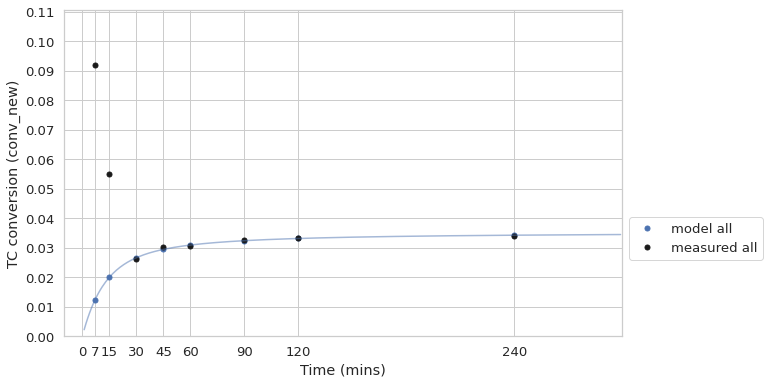

In [100]:
sns.set(style="whitegrid", color_codes=True,font_scale=1.2)
f, ax = plt.subplots(figsize=(10, 6))          


ax.errorbar(x=time0, y=TC_all_pred, 
            fmt='o', ms=5,color='b')
# ax.errorbar(x=time0, y=TC_MT_pred, 
#             fmt='o', ms=5,color='red') 
ax.errorbar(x=time0, y=TC_all_obs2, 
            fmt='o', ms=5,color='k') 
# ax.errorbar(x=time0, y=TC_MT_obs2, 
#             fmt='--o', ms=5,color='k') 
ax.errorbar(x=time_all, y=TC_all_pred_all, color='b',alpha=0.5) 
# ax.errorbar(x=time_all, y=TC_MT_pred_all, color='red',alpha=0.5)


time_plot = [0]
time_plot.extend(list(time0))
plt.xticks(time_plot)
plt.yticks([i*0.01 for i in range(21)])
plt.xlim([-10,T_max])
plt.ylim([0,1.2*max(TC_all_obs2)])
plt.xlabel('Time (mins)')
plt.ylabel('TC conversion (conv_new)')
ax.legend(['model all',
#            'model MT',
           'measured all'],
#            'measured MT'],
          loc='center left', bbox_to_anchor=(1, 0.3))
# plt.title(gene)
# ax.set(xscale="log")
# ax.set(yscale="log") 

### Output results to file

In [98]:
output = pd.DataFrame()
output['time'] = time0
output['conv_new_pred_all'] = TC_all_pred
# output['conv_new_pred_MT'] = TC_MT_pred
output

,time,conv_new_pred_all
0,7,0.012302
1,15,0.019995
2,30,0.026631
3,45,0.029453
4,60,0.030926
5,90,0.032412
6,120,0.033156
7,240,0.034272


In [99]:
path = os.path.join('/n','groups','churchman','mc348','TimelapseSeq','Hela_2020_09',
                    'GS_TL3_MMinformed4_lenient_modeAll')
filename = 'TL3_MMinformed4_lenient_modeAll.binomEstimated_TCpredictions.tsv'
output.to_csv(os.path.join(path,filename), sep='\t',index=False)
 

# OLD scraps

Adjusted example from Pytorch tutorial: `neural_networks_tutorial.ipynb` from source
`https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py`

Example of linear regression with Pytorch:
    https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817